In [9]:

import yaml
import os

from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics

def sortSecond(val):
    return val[1] 
def Photon_density(xoffset,yoffset,X1,X2,spotsize,sigmaT,W,path,w0,a0):
    
    
    Area = pi  * spotsize ** 2
    selector = sqrt( ( xoffset + X1 ) ** 2 + ( yoffset + X2 ) ** 2) < spotsize
    Photon_Density = sum ( W [ selector ]  ) /  Area
    plt.figure(figsize=(14,6))

    

    ax1=plt.subplot(122,aspect=1)
    plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

    plt.xlim(-2*spotsize,2*spotsize)
    plt.ylim(-2*spotsize,2*spotsize)

    plt.xlabel(r'$x$ (micron)')
    plt.ylabel(r'$y$ (micron)');
    plt.title(f'Finite source size, Photon density:{round(Photon_Density,2)} micron^(-2)')


    ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


    plt.suptitle(f' sigmaT :{sigmaT} microns W0 : {w0} microns a0:{round(a0,2)} microns, spotsize:{spotsize} micron')
    plt.savefig(f'{path}\photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)

    


    return ( Photon_Density )
                                      
    
                                   
def run(spotsize,input_filename,path):
    

    
    
    with h5py.File(f'{path}{os.sep}H_Five{os.sep}'+input_filename+'.h5'  ,'r') as ff:
    #     omega      = ff['final-state/spectrum/omega'][:]/1e9
    #     theta      = ff['final-state/spectrum/theta'][:]*1e6
    #     spectrum   = ff['final-state/spectrum/spectrum'][:]

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

        #P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
    #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    #     We            = ff['final-state/photon/weight'  ][:]
    with open( f'{path}{os.sep}Yml_Files{os.sep}'+input_filename+'.yml' , 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)


#         mode             = input_dict['control']['mode']


#         beam_charge      = float( input_dict['beam']['beam_charge'])
#         number_electrons = int( beam_charge / 1.60217653e-19)

    #     sampling         = input_dict['control']['sampling']
#         sampling = mode
        a0               = float(input_dict['laser']['a0'])        
        
        TPulse               = float(input_dict['laser']['Tpulse'])
        w0               = float(input_dict['laser']['w0'])
        omega0           = float(input_dict['laser']['omega0'])
#         gamma            = float(input_dict['beam']['gamma'])
#         Xr               = 4*gamma*omega0/511*10**(-3)
#         energyspread     = float(input_dict['beam']['energyspread'])
        sigmaT   = float(input_dict['beam']['sigmaT'])

    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    
    Pd=Photon_density(xoffset,yoffset,X1,X2,spotsize,sigmaT,W,path,w0,a0)
    
    me=0.511*10**6
    alpha=1/137
    Energy=(TPulse*(me*omega0*a0*w0)**2)/(8*alpha)
    Energy=Energy*0.3/((0.197326)**3)
    
    
    
    return(Pd,sigmaT,Energy)

Files and Directories in 'C:\Users\Dupish\Documents\GitHub\luxeics\Photon_Density\Energy_Conserved_Para_Run_18_10_21':


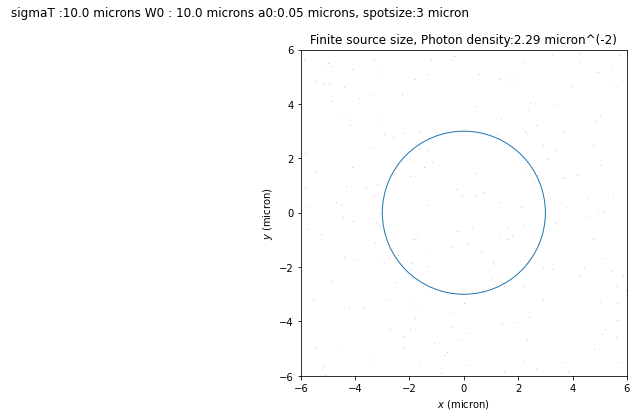

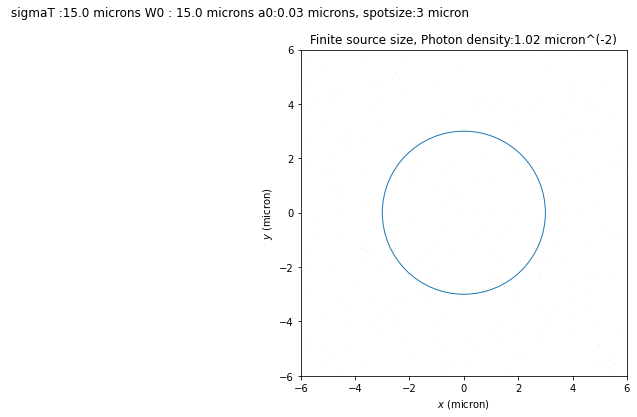

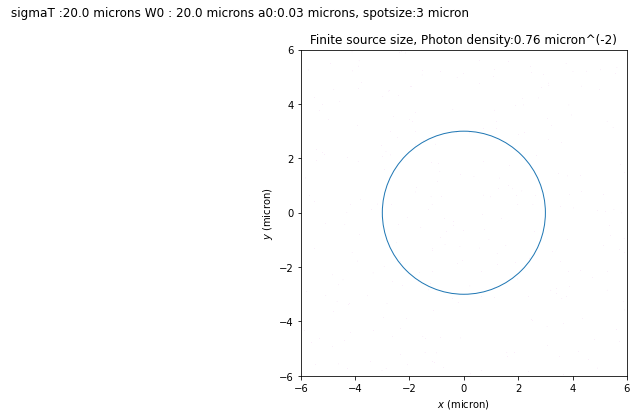

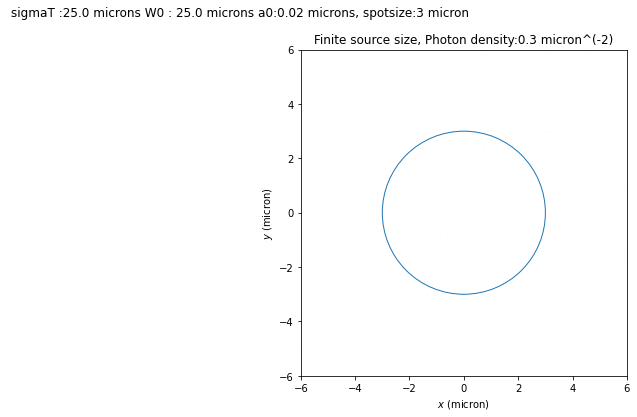

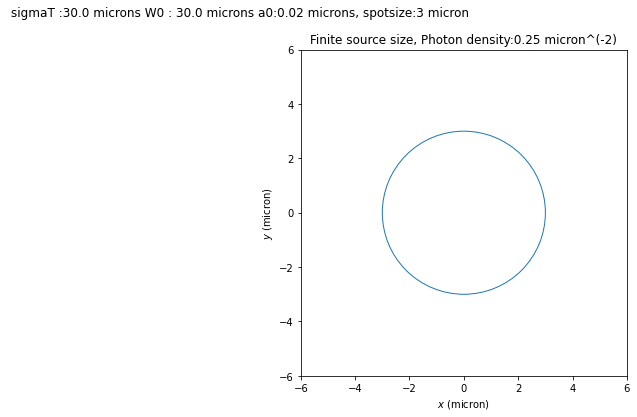

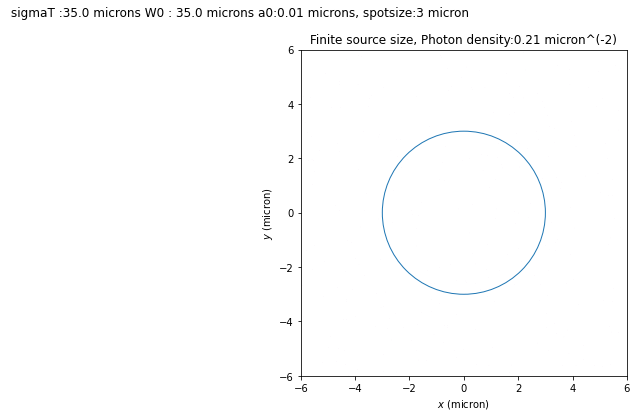

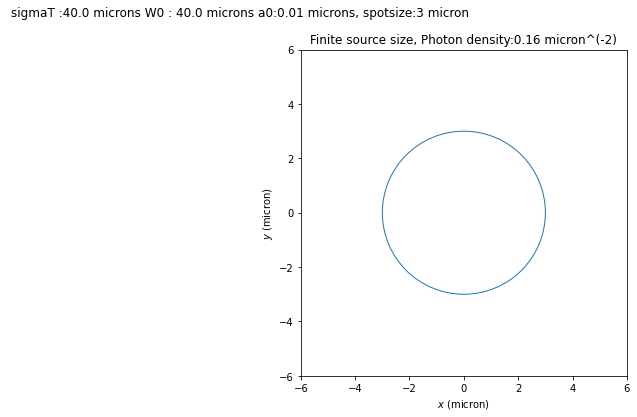

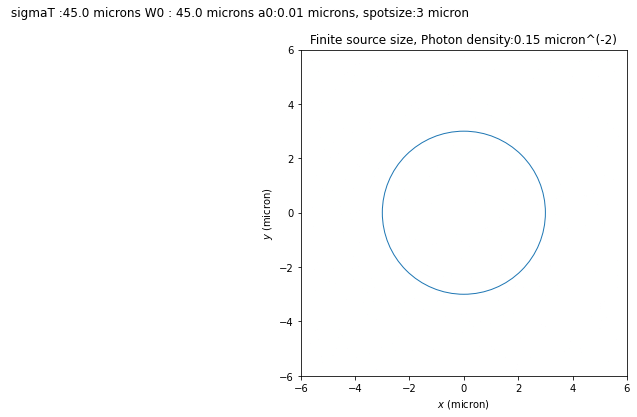

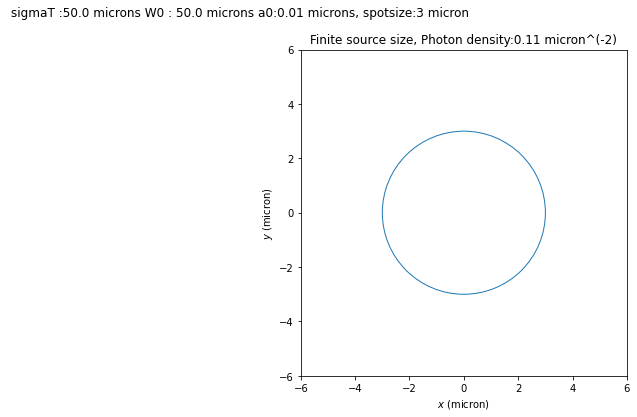

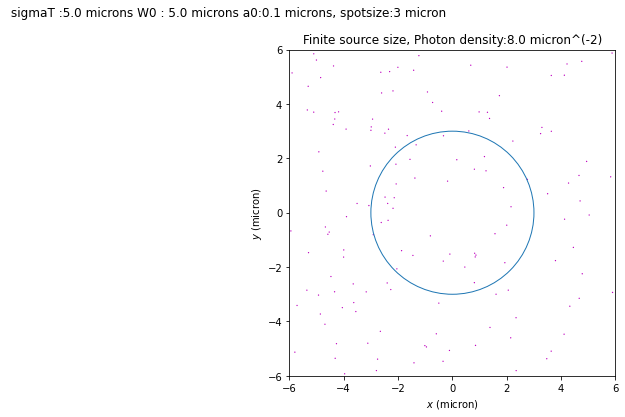

In [11]:

input_filename = "New"

spotsize = 3
with open( input_filename + '.yml', 'r' ) as stream:
               
            
            
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            

            directory	=input_dict['control']['folder']


path = f"{os.getcwd()}{os.sep}Photon_Density{os.sep}{directory}"


object = os.scandir(path+f'{os.sep}H_Five')
print("Files and Directories in '% s':" % path)
PD_Constant_w0 = []
for n in object :
    


        PD_Constant_w0.append( run(spotsize,f'{os.path.splitext(n.name)[0]}', f'{path}'))
        

object.close()


PD_Constant_w0.sort(key = sortSecond)
PD_Constant_w0=array(PD_Constant_w0)

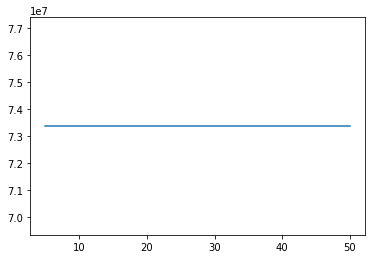

No handles with labels found to put in legend.


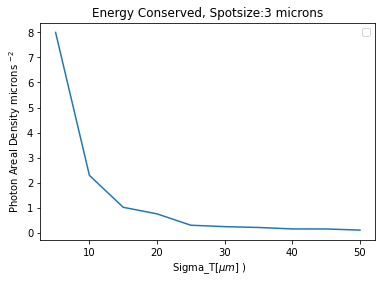

In [13]:
plt.plot(array(PD_Constant_w0)[:,1],array(PD_Constant_w0)[:,2]*10**(-9))
plt.show()
plt.plot(array(PD_Constant_w0)[:,1],array(PD_Constant_w0)[:,0])
plt.xlabel(r' Sigma_T$[\mu m]$ )')
plt.ylabel(r'Photon Areal Density microns $^{-2}$')

plt.title(f'Energy Conserved, Spotsize:{spotsize} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize}_Finite.png',dpi=200)



In [44]:
print(array(PD_Constant_w0)[:,2]*10**(-9))

[  7337.50516766  29350.02067064  66037.54650895 117400.08268257
 183437.62919152 264150.18603579 359537.75321538 469600.33073029
 594337.91858053 733750.51676608]


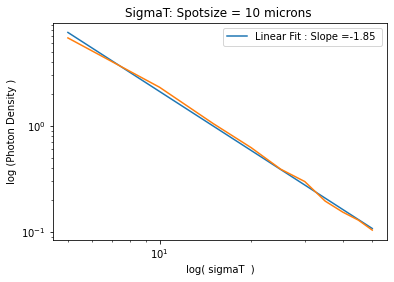

In [12]:
z=(polyfit(log(PD_Constant_w0[:,1].astype('float64')),log(PD_Constant_w0[:,0].astype('float64')),1))
poly = poly1d(z)
x=log(PD_Constant_w0[:,1])
y=poly(x)
plt.plot(exp(x),exp(y),label=f'Linear Fit : Slope ={round(z[0],2)} ')
plt.plot((PD_Constant_w0[:,1]),(PD_Constant_w0[:,0]))
plt.title(f'SigmaT: Spotsize = {spotsize} microns ')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log( sigmaT  )')
plt.ylabel(f'log (Photon Density )')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize}_Finite_Log_Scale.png',dpi=200)


In [13]:
'''
Saving the Data
'''
Pd=PD_Constant_w0

import pandas as pd
import numpy as np
import os
n=np.shape(Pd)
print(n)
Data=np.zeros((n))
Data[:,0]=Pd[:,0]
Data[:,1]=Pd[:,1]
Data[:,2]=Pd[:,2]*10**(-9)

df=pd.DataFrame(Data)

List=["Photon Density ","SigmaT","Energy(GeV)"]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

(10, 3)
          0     1             2
0  6.760889   5.0  7.337505e+07
1  2.313392  10.0  7.337505e+07
2  1.050837  15.0  7.337505e+07
3  0.621803  20.0  7.337505e+07
4  0.389528  25.0  7.337505e+07
5  0.297603  30.0  7.337505e+07
6  0.194595  35.0  7.337505e+07
7  0.153062  40.0  7.337505e+07
8  0.128633  45.0  7.337505e+07
9  0.103480  50.0  7.337505e+07


In [14]:
'''
Reading the text files
The final array p does not contain the Header files

'''
print(pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=None , sep="\t"))

r=pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=0 , sep="\t")
Pd_SigmaT=pd.DataFrame.to_numpy(r)

                      0       1
0       Photon Density   SigmaT
1      7.99673378017644     5.0
2    2.3857494220913247    10.0
3    1.6717391596355902    15.0
4   0.47393886023762766    20.0
5    0.7290948648489659    25.0
6    0.2897461268385033    30.0
7   0.14382581785404272    35.0
8   0.14770198273399832    40.0
9     0.423856015433656    45.0
10   0.5440921226663785    50.0


In [6]:

plt.plot(np.array(Pd_SigmaT)[:,1],np.array(Pd_SigmaT)[:,0],label='W0 = 5 microns [constant]')

plt.plot(np.array(PD_Constant_w0)[:,1],np.array(PD_Constant_w0)[:,0],label='W0=SigmaT')
plt.xlabel(r'Electron Beam Size $\sigmaT=w0$[micron] ')
plt.ylabel('(Photon Areal Density )$[microns]^-2$')

plt.title(f' Spotsize:{spotsize} microns')
plt.legend()
plt.savefig(f'{path}\Combined_Parameter_runs_Spotsize{spotsize}_Finite.png',dpi=200)



NameError: name 'np' is not defined

In [15]:
E =(100 * 10**(-3))  *(6.242*10**18)  # eV
T = 1000 #fs
alpha=1/137
m=511000   #eV
omega=4.1  #eV
a=8*alpha/(m*omega)**2



constant=E*a/T

constant=((0.197326**3)/0.3)*constant


In [18]:
print((constant**0.5)*10)

4.611664199749397
